In [26]:
# for storing probability matrices and distance matrices
import numpy as np

# for transition probability matrices and POS freq distributions
from nltk.probability import ConditionalFreqDist
from nltk.probability import ConditionalProbDist
from nltk.probability import LaplaceProbDist
from nltk.probability import FreqDist 

# for calculating JS divergence
from scipy.stats import entropy

# for clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# for nice pictures
from matplotlib import pyplot as plt

In [5]:
# this is just for testing data
from nltk.corpus import brown

tagged_sentences = brown.tagged_sents(categories= 'news')

tagged_sentences_list  = []
for i in range(10):
    tagged_sentences_list.append(tagged_sentences[i*100:(i+1)*100])

In [6]:
import pickle

tagged_sentences_list = pickle.load(open('pos_tags.p', 'rb'))

In [7]:
## convert the tagged sentences into conditional probability distributions

num_languages = len(tagged_sentences_list)

transition_PD_list = []
tags_FD_list = []
for tagged_sentences in tagged_sentences_list: 
    # the data object should be an array of tuples of conditions and observations
    # in our case the tuples will be of the form (tag_(i),tag_(i+1))
    #data_by_sent = [[(sentence[i][1], sentence[i+1][1]) for i in range(len(sentence) - 1)] for sentence in tagged_sentences]
    #data = [tup for sentence in data_by_sent for tup in sentence]
    data = [(tagged_sentences[i], tagged_sentences[i+1]) for i in range(len(tagged_sentences)-1)]

    # compute the Conditional Frequency Distribution for a tag given the previous tag
    transition_FD = ConditionalFreqDist(data)

    # compute the Conditional Probability Distribution for the
    # transition probability P(tag_(i+1)|tag_(i)) using the MLEProbDist
    # to estimate the probabilities
    transition_PD = ConditionalProbDist(transition_FD, LaplaceProbDist)

    transition_PD_list.append(transition_PD)

    # get POS frequency for each language
    #tags = [word[1] for sentence in tagged_sentences for word in sentence]
    tags_FD = FreqDist(tagged_sentences)
    tags_FD_list.append(tags_FD)

# get a list of common POS tags
pos_set = set(transition_PD_list[0].conditions())
for transition_PD in transition_PD_list:
    pos_set = pos_set.intersection(set(transition_PD))

pos_list = list(pos_set)

In [8]:
## function for getting probabilitity distributions as a matrix
## this should be less hard than it is, seriously
def conditional_PD_to_matrix(conditional_PD):
    prob_matrix = np.zeros(shape=(len(pos_list), len(pos_list)))
    for index, pos_condition in enumerate(pos_list):
        prob_dist = [conditional_PD[pos_condition].prob(pos) for pos in pos_list]
        prob_matrix[index] = prob_dist
    return prob_matrix

## function for distance between two conditional prob dist
def JS_divergence(prob_matrix_1, prob_matrix_2, tags_FD_1, tags_FD_2):
    total_jsd = 0
    total_word_count = sum(tags_FD_1.values()) + sum(tags_FD_2.values()) # total number of words in the 2 languages
    for index, pos in enumerate(pos_list):
        pos_prob = (tags_FD_1.freq(pos) + tags_FD_2.freq(pos))/total_word_count
        jsd = entropy(prob_matrix_1[index], (prob_matrix_1[index] + prob_matrix_2[index])/2) + entropy(prob_matrix_1[index], (prob_matrix_1[index] + prob_matrix_2[index])/2) 
        total_jsd += pos_prob * jsd/2
    return total_jsd 

def frobenius_norm(prob_matrix_1, prob_matrix_2):
    return np.linalg.norm(prob_matrix_1 - prob_matrix_2) #Frobenius norm

In [9]:
# convert list of PD to list of matrices
probdist_matrices = [conditional_PD_to_matrix(PD) for PD in transition_PD_list]

# create similarity matrix
dist_matrix = np.zeros(shape=(num_languages, num_languages))
for i in range(num_languages):
    for j in range(i+1, num_languages):
        dist_matrix[i][j] = JS_divergence(probdist_matrices[i], probdist_matrices[j], tags_FD_list[i], tags_FD_list[j])
dist_matrix = dist_matrix + dist_matrix.T

/var/folders/cg/h5dbfc3547scsqzr5qznln2r0000gr/T/ipykernel_89154/1550496311.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dist_matrix, "average")


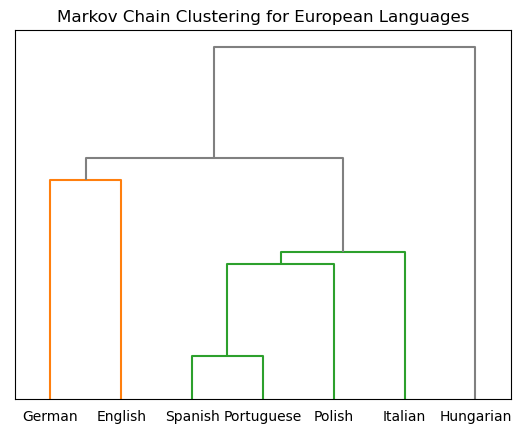

In [39]:
# cluster!

labels = ['English', 'German', 'Hungarian', 'Italian', 'Polish', 'Portuguese', 'Spanish']

linkage_matrix = linkage(dist_matrix, "average")
dendrogram(linkage_matrix, labels=labels, leaf_font_size=10, distance_sort='descending', color_threshold=0.00000025, above_threshold_color='grey')
plt.title("Markov Chain Clustering for European Languages")
ax = plt.gca()
ax.yaxis.set_tick_params(labelleft=False)
ax.set_yticks([])
plt.savefig('Cluster Image.png', dpi=300)
